In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

**Описание данных**

date – дата совершения события\
event - событие\
app_install – установка приложения\
app_start – открыть приложения\
register – зарегистрироваться\
search – перейти на страницу поиска товаров (каталог)\
open_item – открыть товар\
choose_item – отправить товар в корзину\
tap_basket – перейти в корзину\
purchase – подтверждение покупки\
gender – пол пользователя

os_name – платформа пользователя

city – город пользователя

device_id – идентификатор устройства пользователя

urm_source – канал, с которого пришел пользователь

yandex-direct – Яндекс директ\
google_ads – реклама в Google\
vk_ads – реклама в ВК\
instagram_ads – реклама в instagram\
facebook_ads – реклама в facebook\
referal – акция «приведи друга»\
Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы

purchase_sum – стоимость покупки (при совершении события ‘purchase’)

Обратим внимание на следующее:

В выгрузке только уникальные действия пользователей за каждый день

Можно миновать стадию установки приложения, если оно было установлено ранее

Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку.

In [3]:
data = pd.read_csv("KC_case_data.csv")

In [4]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


#### Найдем MAU февраля:

In [5]:
# Поменяем тип данных в столбце дат. Сгруппируем голонку с датами по месяцу и посчиаем количество уникальных значений.

In [6]:
data['date']= pd.to_datetime(data['date'])


In [7]:
data.groupby(data.date.dt.month)['device_id'].nunique()

date
1    99161
2    75032
3    74623
Name: device_id, dtype: int64

In [8]:
# Количество установок в январе:

In [9]:
data.query('event == "app_install"').groupby(data.date.dt.month)['device_id'].count()

date
1    80297
2    38078
3    36222
Name: device_id, dtype: int64

#### Присвоим когорты

Присвоим пользователям когорты по дню установки приложения и посчитайте для них  конверсию из установки в покупку 
в течение 7 дней. Для какой когорты конверсия была наибольшей?

Примечание: считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не 
более 7 дней.

In [10]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [11]:
# Определим дату установки для каждого пользователя
date_install = data.query('event == "app_install"')\
    .groupby('device_id', as_index = False)\
    .agg({'date':'min'})\
    .rename(columns={'date':'date_install'})

In [12]:
date_install.head()

,device_id,date_install
0,4013,2020-01-15
1,4016,2020-01-04
2,4046,2020-01-04
3,4065,2020-03-19
4,4067,2020-01-31


In [13]:
date_merge = data.merge(date_install, how = 'inner', on = 'device_id')

In [14]:
date_merge_purchase = date_merge.query('event =="purchase"')

In [18]:
# Клиенты, которые совершили покупку. Теперь есть датафрейм, в котором клиеты с датами регистрации и покупок.
date_merge_purchase.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_install
13,2020-01-07,purchase,269.0,android,669460,female,Moscow,-,2020-01-01
22,2020-01-09,purchase,4687.5,android,669460,female,Moscow,-,2020-01-01
50,2020-01-01,purchase,329.5,ios,833621,male,Moscow,vk_ads,2020-01-01
62,2020-01-11,purchase,601.0,ios,833621,male,Moscow,referal,2020-01-01
77,2020-01-16,purchase,277.5,ios,833621,male,Moscow,referal,2020-01-01


In [19]:
# Вычислем время которое прошло с момента регистрации до момента покупки
day7_filter = date_merge_purchase['date']-date_merge_purchase['date_install'] <= '7 days' 

In [20]:
# Фильтр разделил на данные, в которых время > 7 и меньше 7
day7_filter.value_counts()

False    59755
True     55470
dtype: int64

In [22]:
# Применим фильтр к нашему датафрейму
date_filter_7days = date_merge_purchase[day7_filter]
date_filter_7days.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_install
13,2020-01-07,purchase,269.0,android,669460,female,Moscow,-,2020-01-01
50,2020-01-01,purchase,329.5,ios,833621,male,Moscow,vk_ads,2020-01-01
525,2020-01-01,purchase,354.5,ios,10144701,female,Moscow,-,2020-01-01
542,2020-01-01,purchase,597.0,android,12374612,male,Moscow,-,2020-01-01
569,2020-01-02,purchase,648.5,ios,12424502,female,Saint-Petersburg,instagram_ads,2020-01-01


In [24]:
# На каждую дату найдем сколько клиентов, которые покупали товар в течении 7 дней с момента регистрации
install_to_7days = date_filter_7days.groupby('date_install', as_index = False).agg({'device_id': 'nunique'}).rename(columns={'device_id': '7_days'})
install_to_7days.head()

,date_install,7_days
0,2020-01-01,1408
1,2020-01-02,1186
2,2020-01-03,834
3,2020-01-04,639
4,2020-01-05,587


In [25]:
# Найдем сколько всего пользователей установило приложение.
install_total = date_install.groupby('date_install', as_index = False).agg({'device_id': 'nunique'}).rename(columns={'device_id': 'total'})
install_total.head()

,date_install,total
0,2020-01-01,3579
1,2020-01-02,3144
2,2020-01-03,2402
3,2020-01-04,1831
4,2020-01-05,1671


In [26]:
# Соединим все в один датафрейм
merge_7days_total = install_to_7days.merge(install_total, how = 'inner', on = 'date_install')

In [27]:
merge_7days_total.head()

,date_install,7_days,total
0,2020-01-01,1408,3579
1,2020-01-02,1186,3144
2,2020-01-03,834,2402
3,2020-01-04,639,1831
4,2020-01-05,587,1671


#### Посчитаем CR (Conversion Rate) для каждой даты.

In [26]:
merge_7days_total['CR'] = round(merge_7days_total['7_days']/merge_7days_total['total']*100, 1)

In [28]:
merge_7days_total.head()

,date_install,7_days,total
0,2020-01-01,1408,3579
1,2020-01-02,1186,3144
2,2020-01-03,834,2402
3,2020-01-04,639,1831
4,2020-01-05,587,1671


#### Построим когортный анализ

In [30]:
date_merge_purchase.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_install
13,2020-01-07,purchase,269.0,android,669460,female,Moscow,-,2020-01-01
22,2020-01-09,purchase,4687.5,android,669460,female,Moscow,-,2020-01-01
50,2020-01-01,purchase,329.5,ios,833621,male,Moscow,vk_ads,2020-01-01
62,2020-01-11,purchase,601.0,ios,833621,male,Moscow,referal,2020-01-01
77,2020-01-16,purchase,277.5,ios,833621,male,Moscow,referal,2020-01-01


In [32]:
# Создадим датафрейм, в котором имеются даты установок и даты покупок
cohorts = date_merge_purchase.drop(['purchase_sum', 'event', 'os_name', 'gender', 'city', 'utm_source'], axis=1)\
        .rename(columns={'date':'purchase_date'})
cohorts.head()

,purchase_date,device_id,date_install
13,2020-01-07,669460,2020-01-01
22,2020-01-09,669460,2020-01-01
50,2020-01-01,833621,2020-01-01
62,2020-01-11,833621,2020-01-01
77,2020-01-16,833621,2020-01-01


In [33]:
# Создадим столбец, который вытащит из нашей даты покупки номер недели
cohorts['purchase_week'] = cohorts['purchase_date'].dt.isocalendar().week

In [34]:
cohorts.head()

,purchase_date,device_id,date_install,purchase_week
13,2020-01-07,669460,2020-01-01,2
22,2020-01-09,669460,2020-01-01,2
50,2020-01-01,833621,2020-01-01,1
62,2020-01-11,833621,2020-01-01,2
77,2020-01-16,833621,2020-01-01,3


In [35]:
# Когорта, дата установки каждого пользователя (группирует по device_id, берет дату установки, 
# и вычисляет минимальную дату установки каждого пользователя. Достает номер недели из даты установки)
cohorts['cohort'] = cohorts.groupby('device_id')['date_install'] \
                 .transform('min') \
                 .dt.isocalendar().week

In [36]:
cohorts.head()

,purchase_date,device_id,date_install,purchase_week,cohort
13,2020-01-07,669460,2020-01-01,2,1
22,2020-01-09,669460,2020-01-01,2,1
50,2020-01-01,833621,2020-01-01,1,1
62,2020-01-11,833621,2020-01-01,2,1
77,2020-01-16,833621,2020-01-01,3,1


In [37]:
# Сгруппируем по когорте (неделя установки) и (неделя покупки), создадим столбец n_customers уникальных пользователей 
data_cohort = cohorts.groupby(['cohort', 'purchase_week']) \
              .agg(n_customers=('device_id', 'nunique')) \
              .reset_index(drop=False)

In [39]:
data_cohort

,cohort,purchase_week,n_customers
0,1,1,3606
1,1,2,2523
2,1,3,2194
3,1,4,1947
4,1,5,1696
...,...,...,...
100,12,13,236
101,12,14,43
102,13,13,2151
103,13,14,93


In [40]:
# добавим период в недеях, между установкой и покупкой
data_cohort['period_number'] = (data_cohort.purchase_week - data_cohort.cohort)

In [41]:
# В итоге получаем: неделя установки, неделя покупки, количество уникальных пользователей, время между установкой и покупкой
data_cohort

,cohort,purchase_week,n_customers,period_number
0,1,1,3606,0
1,1,2,2523,1
2,1,3,2194,2
3,1,4,1947,3
4,1,5,1696,4
...,...,...,...,...
100,12,13,236,1
101,12,14,43,2
102,13,13,2151,0
103,13,14,93,1


In [42]:
# Создаем таблицу когорт, индекс слева - неделя установки,
#                         колонки сверху - период (в течении какой недели купили)
#                         значения - количество уникальных пользователей
cohort_pivot = data_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [43]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
1,3606.0,2523.0,2194.0,1947.0,1696.0,1472.0,1559.0,1515.0,1368.0,1362.0,1269.0,1126.0,1223.0,323.0
2,7274.0,2519.0,1632.0,1276.0,1071.0,1070.0,1049.0,888.0,933.0,750.0,610.0,695.0,156.0,NaN
3,8787.0,1528.0,1061.0,821.0,812.0,767.0,582.0,592.0,477.0,384.0,471.0,93.0,NaN,NaN
4,3071.0,560.0,422.0,393.0,400.0,283.0,320.0,264.0,187.0,244.0,51.0,NaN,NaN,NaN
5,3306.0,615.0,539.0,458.0,331.0,315.0,242.0,212.0,231.0,49.0,NaN,NaN,NaN,NaN
6,2675.0,547.0,431.0,296.0,307.0,219.0,190.0,223.0,44.0,NaN,NaN,NaN,NaN,NaN
7,3447.0,735.0,456.0,465.0,299.0,222.0,282.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2429.0,457.0,361.0,264.0,184.0,224.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1100.0,264.0,174.0,106.0,150.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
cohort_size = cohort_pivot.iloc[:,0] # таблица с пользователями, которые купили в 1 неделю
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0) # разделим весь датафрейм на cohort_size

In [45]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
1,1.0,0.699667,0.608430,0.539933,0.470327,0.408209,0.432335,0.420133,0.379368,0.377704,0.351913,0.312257,0.339157,0.089573
2,1.0,0.346302,0.224361,0.175419,0.147237,0.147099,0.144212,0.122079,0.128265,0.103107,0.083860,0.095546,0.021446,NaN
3,1.0,0.173893,0.120747,0.093433,0.092409,0.087288,0.066234,0.067372,0.054285,0.043701,0.053602,0.010584,NaN,NaN
4,1.0,0.182351,0.137415,0.127971,0.130251,0.092152,0.104201,0.085965,0.060892,0.079453,0.016607,NaN,NaN,NaN
5,1.0,0.186025,0.163037,0.138536,0.100121,0.095281,0.073200,0.064126,0.069873,0.014822,NaN,NaN,NaN,NaN
6,1.0,0.204486,0.161121,0.110654,0.114766,0.081869,0.071028,0.083364,0.016449,NaN,NaN,NaN,NaN,NaN
7,1.0,0.213229,0.132289,0.134900,0.086742,0.064404,0.081810,0.017987,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.188143,0.148621,0.108687,0.075751,0.092219,0.020585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.240000,0.158182,0.096364,0.136364,0.033636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


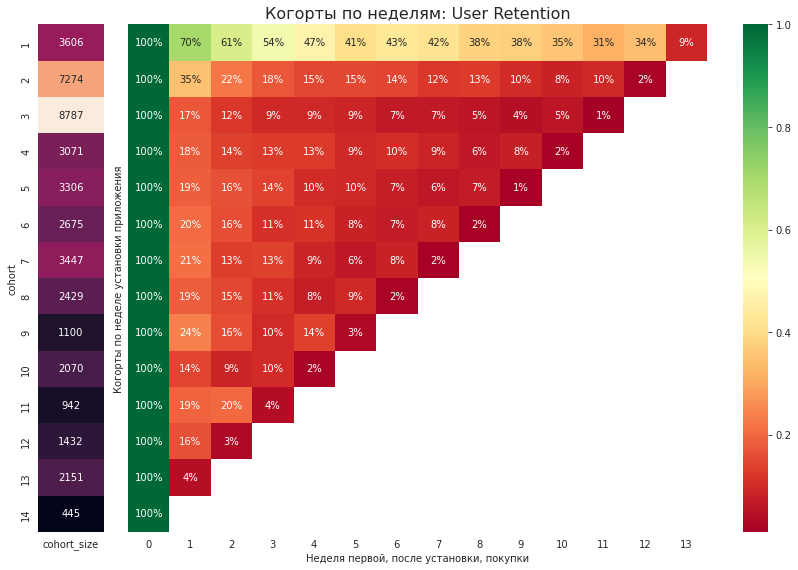

In [70]:
# отобразим когортный анализ в презентабельном виде
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Когорты по неделям: User Retention', fontsize=16)
    ax[1].set(xlabel='Неделя первой, после установки, покупки',
              ylabel='Когорты по неделе установки приложения')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g',                  
                ax=ax[0])

    fig.tight_layout()

На графике, мы можем видеть, что retention резко падает, в два раза для второй когорты, и начиная с третьей когорты больше 80% пользователей не совершает покупки уже на второй неделе.

#### Выясним с какого платного маркетингового канала пришло больше всего новых пользователей? 

In [46]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [47]:
data.query('event == "app_install"')\
    .groupby('utm_source', as_index=False)\
    .agg({'device_id': 'nunique'})\
    .sort_values(by = 'device_id', ascending=False)

,utm_source,device_id
0,-,32460
6,yandex-direct,29368
2,google_ads,26286
5,vk_ads,23189
3,instagram_ads,20096
1,facebook_ads,13916
4,referal,9282


Больше всего пришло с **Яндекса**.

Проанализируем на каком этапе воронки отваливается большая часть клиентов. 
Посмотрим отдельно сценарии для зарегистрированных и для незарегистрированных пользователей. 

- Для того, чтобы выделить группу тех, кому нужно и не нужно регистрироваться, добавьте колонку с датой регистрации. 
Если дата регистрации < даты совершения события, то пользователь уже зарегистрирован. 

In [48]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [49]:
# Создадим фрейм с датой регистрации пользователей
register_date = data.query('event == "register"')\
    .groupby('device_id', as_index=False)\
    .agg({'date': 'min'})\
    .rename(columns={'date':'register_date'})

In [50]:
# Смерджим 2 фрейма LEFT, чтобы к каждому пользователю добавилсь даты регистраций
data_with_regdate = data.merge(register_date, how = 'left', on = 'device_id')

In [51]:
# Создадим воронку (funnel_registred) для незарегистрированных пользователей, где дата регистрации больше даты события.
# Пользователей сгруппируем по событиям и посчитаем количество уникальных.
# Отсортируем по убыванию и дропнем индекс
funnel_registred = data_with_regdate[data_with_regdate['date'] > data_with_regdate['register_date']]\
                                .groupby('event',as_index=False)\
                                .agg({'device_id':'nunique'})\
                                .sort_values(by = 'device_id', ascending=False)\
                                .reset_index().drop(['index'], axis=1)

In [52]:
funnel_registred

,event,device_id
0,app_start,40991
1,search,40482
2,choose_item,37926
3,tap_basket,34517
4,purchase,24880


In [53]:
# Создадим словарь. В котором с помощью функции каждый этап разделим на первоначальный этап device_id[0]
# Получим процентной соотношение.
fun = []
for i in range(5):
    fun.append(round(funnel_registred.device_id[i] *100/funnel_registred.device_id[0]))

In [54]:
fun

[100, 99, 93, 84, 61]

#### Визуально изобразим нашу воронку.

In [58]:
data_percent = dict(
    percent=fun,
    stage=["Start", "Search", "Choose item",  "Top basket", "Purchase"])
fig = px.funnel(data_percent, x='percent', y='stage')
fig.show()

In [59]:
# Построим воронку для всех пользователей

In [60]:
funnel = data.groupby('event',as_index=False).agg({'device_id':'nunique'})\
        .sort_values(by=['device_id'], ascending=False)\
        .reset_index().drop(['index'], axis=1)

In [61]:
funnel

,event,device_id
0,app_start,190884
1,search,184488
2,choose_item,155691
3,app_install,154597
4,tap_basket,125414
5,register,78310
6,purchase,70875


In [62]:
fun2 = []
for i in range(7):
    fun2.append(round(funnel.device_id[i] *100/funnel.device_id[0]))

In [63]:
fun2

[100, 97, 82, 81, 66, 41, 37]

In [64]:
data_percent_all = dict(
    percent=[100, 97, 82, 81, 66, 41, 37],
    stage=["Start", "Search", "Choose item", "Install", "Top basket", "Register", "Purchase"])
fig = px.funnel(data_percent_all, x='percent', y='stage')
fig.show()


Конверсия из шага **«Переход в корзину»** в следующий шаг самая низкая для зарегестрированных и для незарегистрированных пользователей.

**Найдем с каких каналов пришли пользователи и показали самую низкую конверсию в первую покупку.**


- CR = кол-во юзеров, впервые совершивших покупку/кол-во юзеров, впервые открывших приложение 

In [65]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


Так как для нахождения CR нам потребуются пользователи которые купили и которые открыли приложение.
Мы отберем пользователей с такими эвентами, сгруппируем по каналам и эвентам, и найдем количество уникальных.

In [67]:
CR_adds = data.query('event == "app_start" or event == "purchase" ')\
        .groupby(['utm_source', 'event'],as_index=False)\
        .agg({'device_id':'nunique'})
CR_adds

,utm_source,event,device_id
0,-,app_start,52268
1,-,purchase,16598
2,facebook_ads,app_start,25957
3,facebook_ads,purchase,9017
4,google_ads,app_start,38092
5,google_ads,purchase,11339
6,instagram_ads,app_start,31045
7,instagram_ads,purchase,10762
8,referal,app_start,15924
9,referal,purchase,6362


In [68]:
# с помощью pivot подготовим данные для простоты нахождения CR.
CR_adds_pivot = CR_adds.pivot(index="utm_source", columns="event", values="device_id")

In [69]:
CR_adds_pivot

event,app_start,purchase
utm_source,,
-,52268,16598
facebook_ads,25957,9017
google_ads,38092,11339
instagram_ads,31045,10762
referal,15924,6362
vk_ads,34079,12364
yandex-direct,40707,12028


In [70]:
# Поделим столбцы
CR_adds_pivot['CR'] = round(CR_adds_pivot.purchase * 100 / CR_adds_pivot.app_start, 2)

In [71]:
CR_adds_pivot

event,app_start,purchase,CR
utm_source,,,
-,52268,16598,31.76
facebook_ads,25957,9017,34.74
google_ads,38092,11339,29.77
instagram_ads,31045,10762,34.67
referal,15924,6362,39.95
vk_ads,34079,12364,36.28
yandex-direct,40707,12028,29.55


In [72]:
CR_adds_pivot.CR.idxmin()

'yandex-direct'

Cамую низкую конверсию в первую покупку показал **Яндекс**.

#### Найдем с какого канала пришли пользователи, которые имеют медианный первый чек выше
(Будем учитываются только первые покупки пользователей)

In [73]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [74]:
# Отберем данные из фрейма с event покупка, отсортируем по дате, и удалим дубликаты device_id
first_purchase = data.query('event == "purchase"').sort_values('date').drop_duplicates('device_id')

In [76]:
first_purchase.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
7691,2020-01-01,purchase,265.5,android,6081155,female,Moscow,-
8289,2020-01-01,purchase,292.0,ios,1955306,female,Moscow,yandex-direct
8290,2020-01-01,purchase,664.0,ios,20176327,female,Moscow,facebook_ads
8291,2020-01-01,purchase,337.0,android,28603960,male,Moscow,-
8292,2020-01-01,purchase,502.0,ios,14028316,female,Moscow,referal


In [77]:
# Группируем по каналам и выясним медиану покупок у каждого канала
first_purchase.groupby('utm_source').purchase_sum.median().sort_values(ascending=False)

utm_source
-                398.5
referal          395.5
instagram_ads    393.5
vk_ads           393.0
yandex-direct    392.5
google_ads       390.5
facebook_ads     389.0
Name: purchase_sum, dtype: float64

Какой платный канал привлечения (среди рекламных) имеет самый высокий **ROMI**?

**Данные по затратам на рекламу:**

Яндекс – 10 491 707 руб.

Гугл – 10 534 878 руб.

Фейсбук – 8 590 498 руб.

Инстаграм – 8 561626 руб.

ВК – 9 553 531руб.

Расходы на реферальную программу: если пользователь приведет друга и последний совершит первую покупку, то оба получат по 100 рублей. 

**ROMI** = (Валовая прибыль − Маркетинговые расходы) / Маркетинговые расходы


In [78]:
# Вычислим валовую прибыль каждого канала
ROMI = data.groupby('utm_source', as_index=False).agg({'purchase_sum':'sum'})

In [79]:
ROMI

,utm_source,purchase_sum
0,-,21449749.5
1,facebook_ads,12249901.0
2,google_ads,12868276.0
3,instagram_ads,14546969.0
4,referal,8837044.5
5,vk_ads,16389652.5
6,yandex-direct,13915368.0


In [80]:
# Добавим столбец с затратами на маркетинг к каждому каналу
ROMI['marketing_cost'] = [0, 8590498, 10534878,  8561626, 0, 9553531, 10491707]

In [81]:
ROMI

,utm_source,purchase_sum,marketing_cost
0,-,21449749.5,0
1,facebook_ads,12249901.0,8590498
2,google_ads,12868276.0,10534878
3,instagram_ads,14546969.0,8561626
4,referal,8837044.5,0
5,vk_ads,16389652.5,9553531
6,yandex-direct,13915368.0,10491707


In [82]:
# Создадим столбец с ROMI, где рассчитаем его по формуле 
# ROMI = (Валовая прибыль − Маркетинговые расходы) / Маркетинговые расходы
ROMI['ROMI'] = (ROMI.purchase_sum - ROMI.marketing_cost) / ROMI.marketing_cost

In [83]:
ROMI

,utm_source,purchase_sum,marketing_cost,ROMI
0,-,21449749.5,0,inf
1,facebook_ads,12249901.0,8590498,0.425983
2,google_ads,12868276.0,10534878,0.221493
3,instagram_ads,14546969.0,8561626,0.699090
4,referal,8837044.5,0,inf
5,vk_ads,16389652.5,9553531,0.715560
6,yandex-direct,13915368.0,10491707,0.326321


In [84]:
ROMI.sort_values('ROMI', ascending=False)

,utm_source,purchase_sum,marketing_cost,ROMI
0,-,21449749.5,0,inf
4,referal,8837044.5,0,inf
5,vk_ads,16389652.5,9553531,0.715560
3,instagram_ads,14546969.0,8561626,0.699090
1,facebook_ads,12249901.0,8590498,0.425983
6,yandex-direct,13915368.0,10491707,0.326321
2,google_ads,12868276.0,10534878,0.221493


Самый высокий ROMI у канала **ВК**.